In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import time
import shutil
import random
import pickle
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard, TerminateOnNaN
from tqdm import tqdm
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ['PYTHONHASHSEED'] = '3'
np.random.seed(3)
rn.seed(3)

## Global Variables
<br>

In [3]:
batch_size = 64
img_height = 64
img_width = 256
max_label_length = 25  # L
num_primitive_representations = 5  # n
alphabets = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
num_classes = len(alphabets)+3

## Data Pipeline
<br>

In [4]:
train_df = pd.read_csv('Data/train.csv', na_filter=False)
validation_df = pd.read_csv('Data/validation.csv', na_filter=False)
test_df = pd.read_csv('Data/test.csv', na_filter=False)

In [5]:
class LabelEncoderDecoder():
    def __init__(self, max_label_length, alphabets=alphabets):
        
        self.alphabets = alphabets
        
        self.characters_dict = {}
        self.characters_dict['<pad>'] = 0
        self.characters_dict['<eos>'] = 1
        self.characters_dict['<unk>'] = 2

        for i, character in enumerate(self.alphabets):
            self.characters_dict[character] = i+3 

        
    def encode(self, labels):
        
        encoded_labels = []
        
        for label in labels:
            
            encoded_label = []
            
            for character in label:

                if character in self.characters_dict.keys():
                    encoded_label.append(self.characters_dict[character])

                else:
                    encoded_label.append(self.characters_dict['<unk>'])

            if(len(encoded_label)>=max_label_length):
                encoded_label = encoded_label[:max_label_length-1]

            encoded_label.append(self.characters_dict['<eos>'])
                
            if(len(encoded_label)<max_label_length):
                encoded_label+=[self.characters_dict['<pad>']]*(max_label_length-len(encoded_label))

            encoded_labels.append(encoded_label)
    
        return encoded_labels
        
    def decode(self, encoded_labels):
        
        decoded_labels = []
        for label in encoded_labels:
            
            encoded_label = label

            if(tf.is_tensor(label)):
                encoded_label = label.numpy()
            
            end = encoded_label.shape[0]
            
            if(1 in encoded_label):
                end = np.where(encoded_label==1)[0][0]
            
            encoded_label=encoded_label[:end]

            decoder_dict = dict(zip(self.characters_dict.values(), self.characters_dict.keys()))
            
            decoded_label = [decoder_dict[val] for val in encoded_label if val != 0]

            decoded_labels.append(''.join(decoded_label).upper())
        
        return decoded_labels

In [6]:
# Label Encoding and Decoding Example

label_handler = LabelEncoderDecoder(max_label_length, alphabets)

label = np.array(["SCHOOL"])
encoded_label = label_handler.encode(label)
decoded_label = label_handler.decode(np.array(encoded_label))

print("Encoded Label :\n\n", encoded_label)
print("\nDecoded Label :\n\n", decoded_label)

Encoded Label :

 [[31, 15, 20, 27, 27, 24, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

Decoded Label :

 ['SCHOOL']


In [7]:
train_paths = train_df['path'].values
validation_paths = validation_df['path'].values
test_paths = test_df['path'].values

train_encoded_labels = label_handler.encode(train_df['label'].values)
validation_encoded_labels = label_handler.encode(validation_df['label'].values)
test_encoded_labels = label_handler.encode(test_df['label'].values)

In [8]:
def customDataGenerator(paths, labels, batch_size, input_size, is_training=True):
        
    def process_data(path, label):
        img_string = tf.io.read_file(path)
        img = tf.image.decode_image(img_string, channels=1, dtype=tf.float32, expand_animations=False)
        img = tf.image.resize(img, input_size)
        img = tf.image.grayscale_to_rgb(img)
        
        return img, label
    
    dataset = tf.data.Dataset.from_tensor_slices((paths,labels))
    
    if is_training:
        dataset = dataset.shuffle(50000) 
        
    dataset = dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder = True if is_training else False).prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    
    return dataset

In [9]:
train_gen = customDataGenerator(train_paths, train_encoded_labels, batch_size, [img_height, img_width])
validation_gen = customDataGenerator(validation_paths, validation_encoded_labels, batch_size, [img_height, img_width])
test_gen = customDataGenerator(test_paths, test_encoded_labels, batch_size, [img_height, img_width], False)

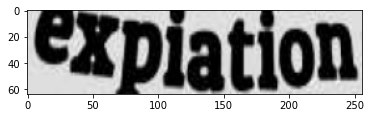

Label:  EXPIATION


In [10]:
for x,y in train_gen:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(x[0]))
    plt.show()
    print("Label: ", label_handler.decode([y[0]])[0])
    break

## Feature Extraction Module
<br>

In [11]:
class FeatureExtractionModule(tf.keras.Model):
    def __init__(self):
        super(FeatureExtractionModule, self).__init__()
        
        self.enb3 = tf.keras.applications.efficientnet.EfficientNetB3(
                       include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)
                    )
        
        for layer in self.enb3.layers:
            layer.trainable = False

        self.block3 = tf.keras.Model(self.enb3.input, self.enb3.get_layer('block3c_add').output, name='block3')
        self.block5 = tf.keras.Model(self.enb3.input, self.enb3.get_layer('block5e_add').output, name='block5')
        self.block7 = tf.keras.Model(self.enb3.input, self.enb3.get_layer('block7b_add').output, name='block7')   
        
        for layer in self.block7.layers:
            layer.trainable = True 
            

    @tf.function
    def call(self, input): # (64, 256, 3)
                
        block3_output = self.block3(input) # (8, 32, 48)
        block5_output = self.block5(input) # (4, 16, 136)
        block7_output = self.block7(input) # (2, 8, 384)
                
        return (block3_output, block5_output, block7_output)

## Custom Activation Function
<br>

In [12]:
class CustomActivation(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.swish = tf.nn.silu # x * sigmoid(x)
    
    @tf.function       
    def call(self, input):
        return self.swish(input)

## Primitive Representation Learning Module
<br>

### Pooling Aggregator
<br>

In [13]:
class PoolingAggregatorSubblock(tf.keras.Model):
    def __init__(self, d0, d):
        super(PoolingAggregatorSubblock, self).__init__()

        self.pool_block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(d0, 3, 2, padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(momentum = 0.01, epsilon = 0.001),
            CustomActivation(),
            tf.keras.layers.Conv2D(d, 3, 2, padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(momentum = 0.01, epsilon = 0.001),
            tf.keras.layers.GlobalAveragePooling2D(),      
        ])
        
    @tf.function       
    def call(self, input):
        return tf.expand_dims(self.pool_block(input), axis=1)

In [14]:
class PoolingAggregator(tf.keras.Model):
    def __init__(self, n, d0, d):
        super(PoolingAggregator, self).__init__()
        self.blocks = []
        self.d = d
        for i in range(n):
            self.blocks.append(PoolingAggregatorSubblock(d0, d))

    @tf.function       
    def call(self, input):
        
        P = None
        
        for block in self.blocks:
            x = block(input)
            if(P is None):
                P = x
            else:
                P = tf.concat([P, x], axis=1)
        
        return P

### Weighted Aggregator
<br>

In [15]:
class WeightedAggregator(tf.keras.Model):
    def __init__(self, n, d0, d):
        super(WeightedAggregator, self).__init__()

        self.conv_d = tf.keras.Sequential([
            tf.keras.layers.Conv2D(4*d0, 3, 1, padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(momentum = 0.01, epsilon = 0.001),
            CustomActivation(),
            tf.keras.layers.Conv2D(d, 1, padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(momentum = 0.01, epsilon = 0.001)
        ])

        self.conv_n = tf.keras.Sequential([
            tf.keras.layers.Conv2D(d0, 3, 1, padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(momentum = 0.01, epsilon = 0.001),
            CustomActivation(),
            tf.keras.layers.Conv2D(n, 1, padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(momentum = 0.01, epsilon = 0.001),
            tf.keras.layers.Activation('sigmoid')
        ])
    
    @tf.function       
    def call(self, input): 

        Z = self.conv_d(input)
        H = self.conv_n(input)
              
        Z = tf.transpose(Z, perm = [0, 3, 1, 2])
        H = tf.transpose(H, perm = [0, 3, 1, 2])
          
        Z = tf.transpose(tf.reshape(Z, [-1, Z.shape[1], Z.shape[2]*Z.shape[3]]), perm=[0,2,1])
        H = tf.reshape(H,[-1, H.shape[1], H.shape[2]*H.shape[3]])
    
        P = tf.matmul(H,Z)
        
        return P

### Graph Convolution Network
<br>

In [16]:
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, L):
        super(GCNLayer, self).__init__()
        self.L = L
    
    def build(self, input_shape):

        self.B = self.add_weight('B', shape=[self.L, input_shape[1]], trainable=True)
        
        self.W = self.add_weight('W', shape=[input_shape[2], input_shape[2]], trainable=True)
    
    @tf.function                  
    def call(self, P):

        return tf.matmul(tf.matmul(self.B, P), self.W)        

### Primitive Representation Learning Module 
<br>

In [17]:
class PrimitiveRepresentationLearningModule(tf.keras.Model):
    def __init__(self, L, n, d03, d05, d07, d):
        
        super(PrimitiveRepresentationLearningModule, self).__init__()
        
        self.pa1 = PoolingAggregator(n, d03, d//3);
        self.pa2 = PoolingAggregator(n, d05, d//3);
        self.pa3 = PoolingAggregator(n, d07, d//3);

        self.wa1 = WeightedAggregator(n, d03, d//3);        
        self.wa2 = WeightedAggregator(n, d05, d//3);
        self.wa3 = WeightedAggregator(n, d07, d//3);
        
        self.concat1 = tf.keras.layers.concatenate
        self.concat2 = tf.keras.layers.concatenate
        
        self.dropout = tf.keras.layers.Dropout(0.1)
        
        self.gcn1 = GCNLayer(L)
        self.gcn2 = GCNLayer(L)

        self.activation = CustomActivation()

    @tf.function       
    def call(self, input):
        
        pa1_output = self.pa1(input[0]) # Primitive Representation 1 (nXd/3)
        pa2_output = self.pa2(input[1]) # Primitive Representation 2 (nXd/3)
        pa3_output = self.pa3(input[2]) # Primitive Representation 3 (nXd/3)

        wa1_output = self.wa1(input[0]) # Primitive Representation 1 (nXd/3)
        wa2_output = self.wa2(input[1]) # Primitive Representation 2 (nXd/3)
        wa3_output = self.wa3(input[2]) # Primitive Representation 3 (nXd/3)
        
        P1 = self.concat1([pa1_output, pa2_output, pa3_output], axis=-1) # Concatenated Primitive Representation 1 (nXd)
        P2 = self.concat1([wa1_output, wa2_output, wa3_output], axis=-1) # Concatenated Primitive Representation 2 (nXd)
        
        Y1 = self.activation(self.dropout(self.gcn1(P1))) # Visual Text Representation 1 (LXd)
        Y2 = self.activation(self.dropout(self.gcn2(P2))) # Visual Text Representation 2 (LXd)
                
        return tf.add(Y1,Y2)/2. # Fused Visual Text Representation (Lxd)

## PREN
<br>

In [18]:
class PREN(tf.keras.Model):
    def __init__(self, L, n, num_classes):
        super(PREN, self).__init__()

        self.featureExtractor = FeatureExtractionModule()        

        self.d03 = self.featureExtractor.get_layer('block3').output.shape[-1]
        self.d05 = self.featureExtractor.get_layer('block5').output.shape[-1]
        self.d07 = self.featureExtractor.get_layer('block7').output.shape[-1]
        self.d = self.featureExtractor.get_layer('block7').output.shape[-1]        

        self.primitiveRepresentationLearner = PrimitiveRepresentationLearningModule(L, n, self.d03, self.d05, self.d07, self.d)
        
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    @tf.function       
    def call(self, input):

        f3, f5, f7 = self.featureExtractor(input)
        Y = self.primitiveRepresentationLearner((f3, f5, f7))
        logits = self.fc(Y) # (LXnum_classes)
        
        return logits

## Training
<br>

In [19]:
model = PREN(max_label_length, num_primitive_representations, num_classes)

In [20]:
tf.keras.backend.clear_session()

In [21]:
# Custom Loss Function to ignore the padded part while computing Loss

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) #Using SparseCategorical Cross Entropy to avoid one-hot-encoding the encoded ground truth labels
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(0.5), loss=loss_function, metrics=['accuracy'])

In [23]:
def changeLearningRate(epoch, lr):
    if(epoch):
        lr = lr*0.9 # Reducing the learning rate by 90% at every epoch after the first epoch
    return lr

In [24]:
earlystop = EarlyStopping(min_delta=1e-2, patience = 3, verbose=1, monitor='val_accuracy', mode='max', restore_best_weights=True)

lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

log_dir = "Saves/model_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

terminateNaN = TerminateOnNaN()

In [25]:
model.fit(
    train_gen,
    steps_per_epoch = len(train_df)//batch_size,
    validation_data = validation_gen, 
    validation_steps = len(validation_df)//batch_size,
    epochs = 15,
    callbacks=[earlystop, lrschedule, tensorboard, terminateNaN]
)

model.save(f"Saves/model_save/final_model", save_format='tf')

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 0.5.
4687/4687 [==============================] - 2408s 507ms/step - loss: 0.2215 - accuracy: 0.8149 - val_loss: 0.1077 - val_accuracy: 0.9043
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 0.45.
4687/4687 [==============================] - 2370s 506ms/step - loss: 0.0833 - accuracy: 0.9269 - val_loss: 0.0687 - val_accuracy: 0.9409
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.40499998927116393.
4687/4687 [==============================] - 2376s 507ms/step - loss: 0.0578 - accuracy: 0.9503 - val_loss: 0.0545 - val_accuracy: 0.9539
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.3645000010728836.
4687/4687 [==============================] - 2374s 506ms/step - loss: 0.0461 - accuracy: 0.9607 - val_loss: 0.0473 - val_accuracy: 0.9598
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 0.32804998755455017.
4687/4687 

<br>
<h4>Epoch vs Loss </h4>
<img src=https://i.ibb.co/DKvtBV8/Screenshot-from-2021-07-19-17-22-56.png>
<h4>Epoch vs Accuracy </h4>
<img src=https://i.ibb.co/gPqsnSc/Screenshot-from-2021-07-19-17-22-50.png>

## Evaluating
<br>

In [26]:
# Evaluating the Model Performance on the Test Data

scores = model.evaluate(test_gen, steps = np.floor(len(test_df)/batch_size), verbose=1)

print("\nLoss on Test Data : {}".format(scores[0]))
print("Accuracy on Test Data : {}\n".format(scores[1]))

1250/1250 [==============================] - 130s 98ms/step - loss: 0.0342 - accuracy: 0.9714

Loss on Test Data : 0.03423260524868965
Accuracy on Test Data : 0.9714404940605164



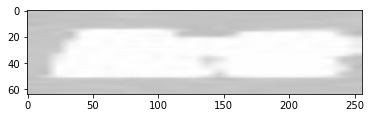

Original: KT
Predicted: BISEE



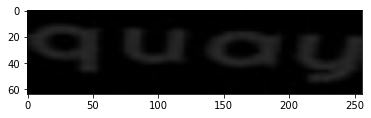

Original: QUAY
Predicted: QUAY



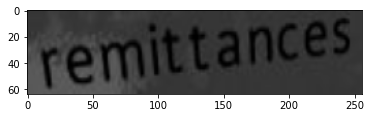

Original: REMITTANCES
Predicted: REMITTANCES



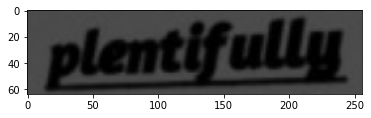

Original: PLENTIFULLY
Predicted: PLENTIFULLY



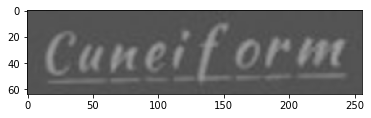

Original: CUNEIFORM
Predicted: CUNEIFORM



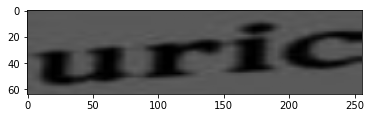

Original: URIC
Predicted: URIC



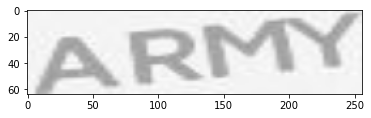

Original: ARMY
Predicted: ARMY



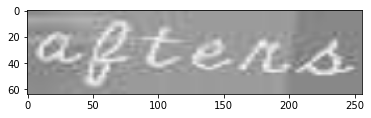

Original: AFTERS
Predicted: APTERS



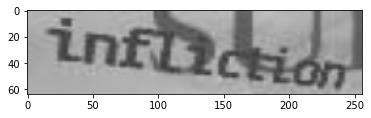

Original: INFLICTION
Predicted: INFBICIION



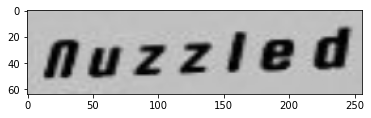

Original: NUZZLED
Predicted: NUZZLED



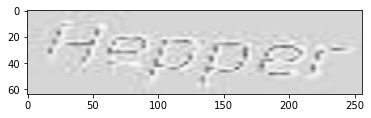

Original: HEPPER
Predicted: HAPPER



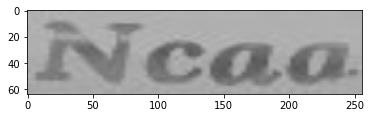

Original: NCAA
Predicted: NCAA



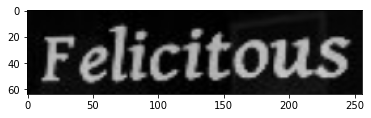

Original: FELICITOUS
Predicted: FELICITOUS



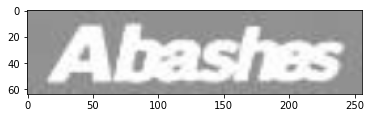

Original: ABASHES
Predicted: ABASHES



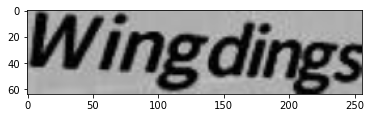

Original: WINGDINGS
Predicted: WINGDINGS



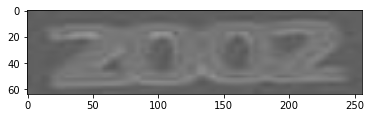

Original: 2002
Predicted: Z00Z



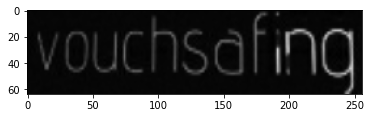

Original: VOUCHSAFING
Predicted: VOUCHSAFING



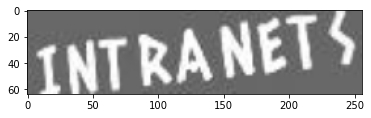

Original: INTRANETS
Predicted: INTRANETS



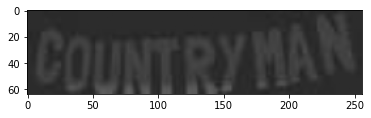

Original: COUNTRYMAN
Predicted: COUNTRYMAN



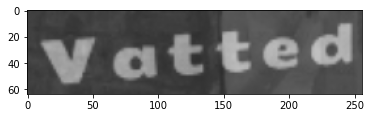

Original: VATTED
Predicted: VATTED



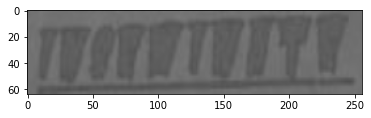

Original: INSEMINATE
Predicted: TARRIAIIA



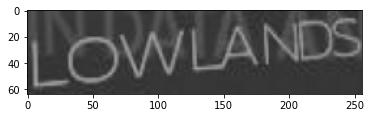

Original: LOWLANDS
Predicted: LOWLANDDS



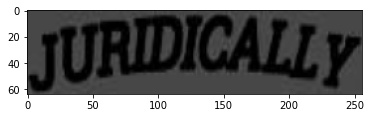

Original: JURIDICALLY
Predicted: JURIDICALL



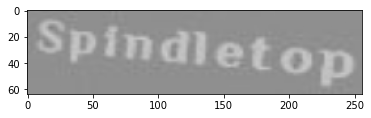

Original: SPINDLETOP
Predicted: SPINDLETOP



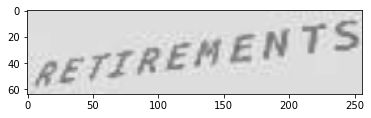

Original: RETIREMENTS
Predicted: RETTREMENTS



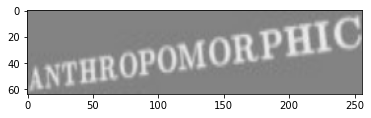

Original: ANTHROPOMORPHIC
Predicted: INTEHOOPOOOPPHIH



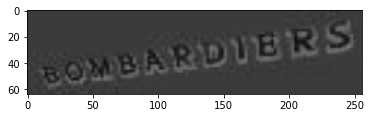

Original: BOMBARDIERS
Predicted: COMBARDDERS



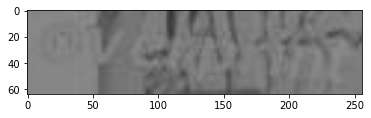

Original: OVERPRINT
Predicted: OVERRIIT



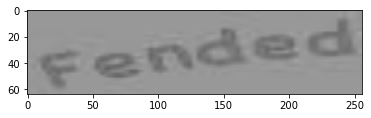

Original: FENDED
Predicted: FENDED



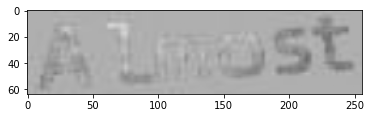

Original: ALMOST
Predicted: ALMOST



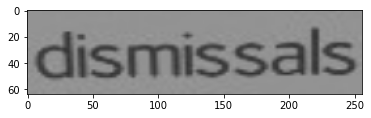

Original: DISMISSALS
Predicted: DISMISSALS



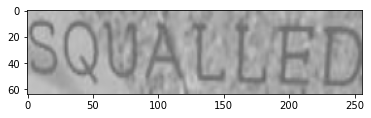

Original: SQUALLED
Predicted: SQUALLED



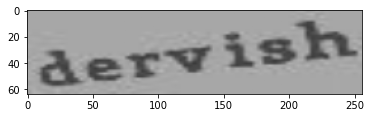

Original: DERVISH
Predicted: DERVISH



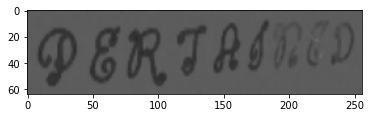

Original: PERTAINED
Predicted: PERTHIRED



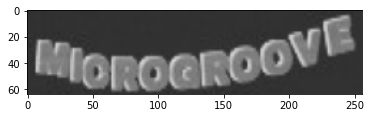

Original: MICROGROOVE
Predicted: HITROGROOVE



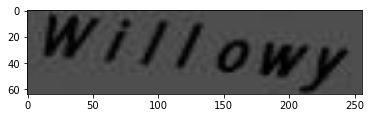

Original: WILLOWY
Predicted: WILLOWY



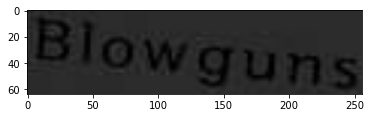

Original: BLOWGUNS
Predicted: BLOWGUNS



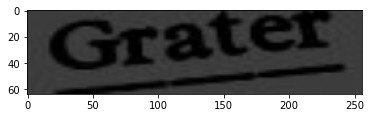

Original: GRATER
Predicted: GRATER



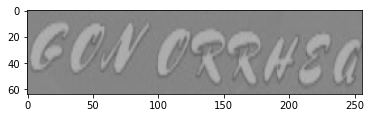

Original: GONORRHEA
Predicted: CONVERHEA



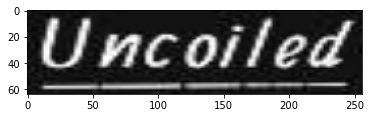

Original: UNCOILED
Predicted: UNCOILED



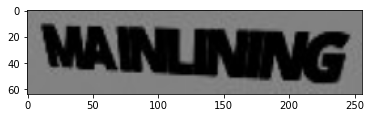

Original: MAINLINING
Predicted: WAINLINING



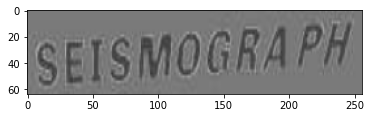

Original: SEISMOGRAPH
Predicted: SEISMOGRAPH



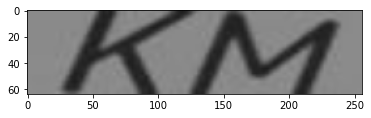

Original: KM
Predicted: KM



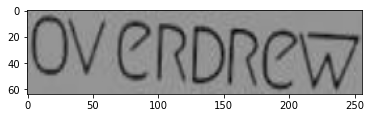

Original: OVERDREW
Predicted: OVERDREW



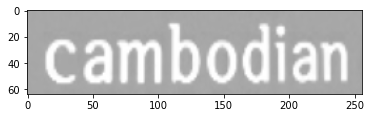

Original: CAMBODIAN
Predicted: CAMBODIAN



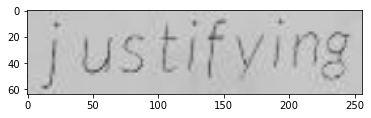

Original: JUSTIFYING
Predicted: JUSTIFYING



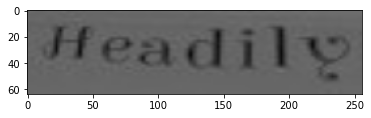

Original: HEADILY
Predicted: HEADILY



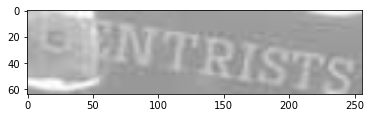

Original: CENTRISTS
Predicted: GGNTRISTS



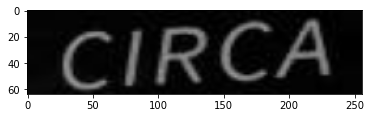

Original: CIRCA
Predicted: CIRCA



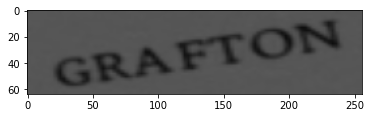

Original: GRAFTON
Predicted: GRAFTON



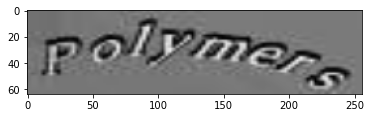

Original: POLYMERS
Predicted: POLYMERS



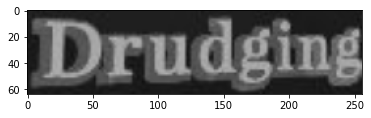

Original: DRUDGING
Predicted: DRUDGING



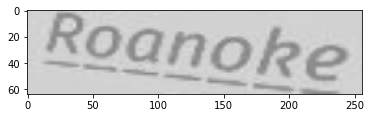

Original: ROANOKE
Predicted: ROANOKE



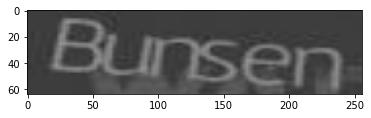

Original: BUNSEN
Predicted: BUNSEN



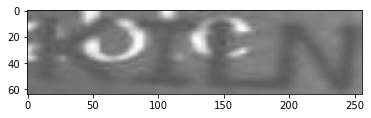

Original: KILN
Predicted: RORN



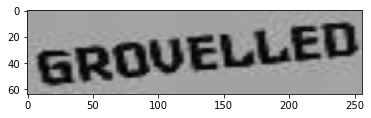

Original: GROVELLED
Predicted: GROUELLED



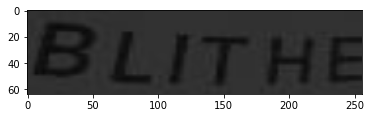

Original: BLITHE
Predicted: BLITHE



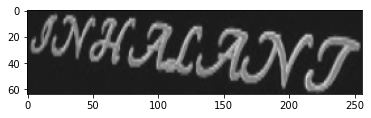

Original: INHALANT
Predicted: DONALLANN



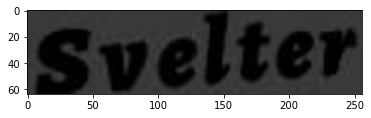

Original: SVELTER
Predicted: SVELTER



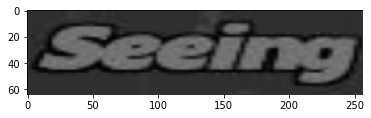

Original: SEEING
Predicted: SEEING



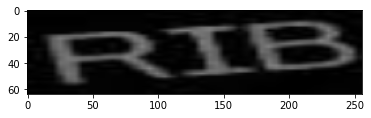

Original: RIB
Predicted: RIB



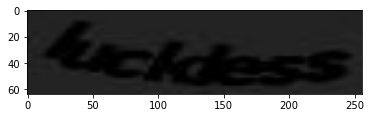

Original: LUCKLESS
Predicted: LUCKDESS



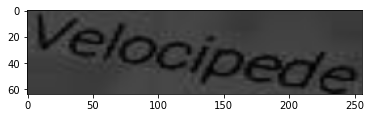

Original: VELOCIPEDE
Predicted: VELOCIPEDD



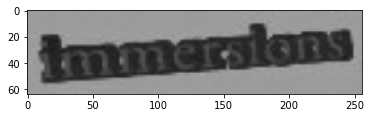

Original: IMMERSIONS
Predicted: IMMERSIONS



In [27]:
# Predicting for a single batch in test data

images, labels = next(iter(test_gen))

images = images.numpy()
labels = labels.numpy()

predictions = tf.argmax(model.predict(images), axis=2)
        
for idx, image in enumerate(images):
    plt.imshow(image)
    plt.show()
    print(f"Original: {label_handler.decode([labels[idx]])[0]}")
    print(f"Predicted: {label_handler.decode([predictions[idx]])[0]}\n")

In [28]:
# Making predictions for the complete test data and storing them locally

original_test_labels = []
predicted_test_labels = []

iterations = np.floor(len(test_df)/batch_size)

for images, labels in iter(tqdm(test_gen)):
    
    images = images.numpy()
    labels = labels.numpy()
    predictions = tf.argmax(model.predict(images), axis=2)

    for idx, prediction in enumerate(predictions):
        predicted_test_labels.append(label_handler.decode([prediction])[0])
        original_test_labels.append(label_handler.decode([labels[idx]])[0])
        
    iterations-=1
    
    if(not iterations):
        break
    
test_predictions_df = pd.DataFrame({'original':original_test_labels, 'predicted':predicted_test_labels})
test_predictions_df.to_csv('test_predictions.csv', index=False)

1249it [03:37,  5.76it/s]
